### Notebook based on https://github.com/fastai/fastbook/blob/master/12_nlp_dive.ipynb

In [1]:
from pathlib import Path
import torch
import torch.nn as nn
import numpy as np

In [5]:
from fastai.text.all import *
path = untar_data(URLs.HUMAN_NUMBERS)

In [6]:
Path.BASE_PATH = path
path.ls()

(#2) [Path('train.txt'),Path('valid.txt')]

# Read lines

In [7]:
#path = Path("../../Datasets/NLP/English numbers")

train_file = open(path/'train.txt', 'r')
valid_file = open(path/'valid.txt', 'r')

train_lines = train_file.readlines()
valid_lines = valid_file.readlines()

train_lines = [l.strip() for l in train_lines] # Remove " \n" at the end of the line
valid_lines = [l.strip() for l in valid_lines] # Remove " \n" at the end of the line

lines = train_lines + valid_lines

print(len(lines))
print(lines[:10])
print(lines[-2:])

9998
['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']
['nine thousand nine hundred ninety eight', 'nine thousand nine hundred ninety nine']


# Create corpus

In [8]:
text = ' . '.join(lines)
text[:1000]

'one . two . three . four . five . six . seven . eight . nine . ten . eleven . twelve . thirteen . fourteen . fifteen . sixteen . seventeen . eighteen . nineteen . twenty . twenty one . twenty two . twenty three . twenty four . twenty five . twenty six . twenty seven . twenty eight . twenty nine . thirty . thirty one . thirty two . thirty three . thirty four . thirty five . thirty six . thirty seven . thirty eight . thirty nine . forty . forty one . forty two . forty three . forty four . forty five . forty six . forty seven . forty eight . forty nine . fifty . fifty one . fifty two . fifty three . fifty four . fifty five . fifty six . fifty seven . fifty eight . fifty nine . sixty . sixty one . sixty two . sixty three . sixty four . sixty five . sixty six . sixty seven . sixty eight . sixty nine . seventy . seventy one . seventy two . seventy three . seventy four . seventy five . seventy six . seventy seven . seventy eight . seventy nine . eighty . eighty one . eighty two . eighty thre

# Tokenize corpus
### Simple tokenization by crating a token for each word

In [9]:
text_tokens = text.split(' ')
text_tokens[:10]

['one', '.', 'two', '.', 'three', '.', 'four', '.', 'five', '.']

In [10]:
vocab = set(text_tokens)
vocab

{'.',
 'eight',
 'eighteen',
 'eighty',
 'eleven',
 'fifteen',
 'fifty',
 'five',
 'forty',
 'four',
 'fourteen',
 'hundred',
 'nine',
 'nineteen',
 'ninety',
 'one',
 'seven',
 'seventeen',
 'seventy',
 'six',
 'sixteen',
 'sixty',
 'ten',
 'thirteen',
 'thirty',
 'thousand',
 'three',
 'twelve',
 'twenty',
 'two'}

## Numericalization: Convert each token to an integer

In [11]:
idx2word = {i:w for i,w in enumerate(vocab)}
idx2word

{0: 'ten',
 1: 'two',
 2: 'seven',
 3: 'sixty',
 4: 'fifty',
 5: 'eight',
 6: 'seventy',
 7: 'five',
 8: 'twenty',
 9: 'nineteen',
 10: 'hundred',
 11: 'thousand',
 12: 'fifteen',
 13: 'one',
 14: 'ninety',
 15: 'sixteen',
 16: 'eighteen',
 17: 'eleven',
 18: 'four',
 19: 'thirteen',
 20: 'twelve',
 21: 'nine',
 22: '.',
 23: 'fourteen',
 24: 'eighty',
 25: 'three',
 26: 'six',
 27: 'seventeen',
 28: 'thirty',
 29: 'forty'}

In [12]:
word2idx = {w:i for i,w in enumerate(vocab)}
word2idx

{'ten': 0,
 'two': 1,
 'seven': 2,
 'sixty': 3,
 'fifty': 4,
 'eight': 5,
 'seventy': 6,
 'five': 7,
 'twenty': 8,
 'nineteen': 9,
 'hundred': 10,
 'thousand': 11,
 'fifteen': 12,
 'one': 13,
 'ninety': 14,
 'sixteen': 15,
 'eighteen': 16,
 'eleven': 17,
 'four': 18,
 'thirteen': 19,
 'twelve': 20,
 'nine': 21,
 '.': 22,
 'fourteen': 23,
 'eighty': 24,
 'three': 25,
 'six': 26,
 'seventeen': 27,
 'thirty': 28,
 'forty': 29}

In [15]:
text_nums = [word2idx[i] for i in text_tokens]
print(text_tokens[:10])
print(text_nums[:10])

['one', '.', 'two', '.', 'three', '.', 'four', '.', 'five', '.']
[13, 22, 1, 22, 25, 22, 18, 22, 7, 22]


## Language model: Dataset
### Predict each word based on the previous three words

In [13]:
[(text_tokens[i:i+3], text_tokens[i+3]) for i in range(0, len(text_tokens)-4, 3)]

[(['one', '.', 'two'], '.'),
 (['.', 'three', '.'], 'four'),
 (['four', '.', 'five'], '.'),
 (['.', 'six', '.'], 'seven'),
 (['seven', '.', 'eight'], '.'),
 (['.', 'nine', '.'], 'ten'),
 (['ten', '.', 'eleven'], '.'),
 (['.', 'twelve', '.'], 'thirteen'),
 (['thirteen', '.', 'fourteen'], '.'),
 (['.', 'fifteen', '.'], 'sixteen'),
 (['sixteen', '.', 'seventeen'], '.'),
 (['.', 'eighteen', '.'], 'nineteen'),
 (['nineteen', '.', 'twenty'], '.'),
 (['.', 'twenty', 'one'], '.'),
 (['.', 'twenty', 'two'], '.'),
 (['.', 'twenty', 'three'], '.'),
 (['.', 'twenty', 'four'], '.'),
 (['.', 'twenty', 'five'], '.'),
 (['.', 'twenty', 'six'], '.'),
 (['.', 'twenty', 'seven'], '.'),
 (['.', 'twenty', 'eight'], '.'),
 (['.', 'twenty', 'nine'], '.'),
 (['.', 'thirty', '.'], 'thirty'),
 (['thirty', 'one', '.'], 'thirty'),
 (['thirty', 'two', '.'], 'thirty'),
 (['thirty', 'three', '.'], 'thirty'),
 (['thirty', 'four', '.'], 'thirty'),
 (['thirty', 'five', '.'], 'thirty'),
 (['thirty', 'six', '.'], 'thirty

In [16]:
dataset = [( torch.tensor(text_nums[i:i+3]),
             torch.tensor(text_nums[i+3])   ) for i in range(0, len(text_nums)-4, 3)]
print(len(dataset))
dataset

21031


[(tensor([13, 22,  1]), tensor(22)),
 (tensor([22, 25, 22]), tensor(18)),
 (tensor([18, 22,  7]), tensor(22)),
 (tensor([22, 26, 22]), tensor(2)),
 (tensor([ 2, 22,  5]), tensor(22)),
 (tensor([22, 21, 22]), tensor(0)),
 (tensor([ 0, 22, 17]), tensor(22)),
 (tensor([22, 20, 22]), tensor(19)),
 (tensor([19, 22, 23]), tensor(22)),
 (tensor([22, 12, 22]), tensor(15)),
 (tensor([15, 22, 27]), tensor(22)),
 (tensor([22, 16, 22]), tensor(9)),
 (tensor([ 9, 22,  8]), tensor(22)),
 (tensor([22,  8, 13]), tensor(22)),
 (tensor([22,  8,  1]), tensor(22)),
 (tensor([22,  8, 25]), tensor(22)),
 (tensor([22,  8, 18]), tensor(22)),
 (tensor([22,  8,  7]), tensor(22)),
 (tensor([22,  8, 26]), tensor(22)),
 (tensor([22,  8,  2]), tensor(22)),
 (tensor([22,  8,  5]), tensor(22)),
 (tensor([22,  8, 21]), tensor(22)),
 (tensor([22, 28, 22]), tensor(28)),
 (tensor([28, 13, 22]), tensor(28)),
 (tensor([28,  1, 22]), tensor(28)),
 (tensor([28, 25, 22]), tensor(28)),
 (tensor([28, 18, 22]), tensor(28)),
 (te

### Split dataset in train (80%) / valid (20%)

In [17]:
bs = 64
train_val_threshold = int(len(dataset) * 0.8)
train_val_threshold

16824

In [18]:
train_ds = dataset[:train_val_threshold]
valid_ds = dataset[train_val_threshold:]

## Language model: Dataloader
### Predict each word based on the previous three words

In [19]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=False, drop_last=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=bs, shuffle=False, drop_last=True)

# Language model: RNN Model

In [20]:
class LMModel(nn.Module):
    
    def __init__(self, vocab_sz, n_hidden, n_layers, dropout_p, bs):
        super(LMModel, self).__init__()
        self.i_h  = nn.Embedding(vocab_sz, n_hidden)
        self.rnn  = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.drop = nn.Dropout(dropout_p)
        self.h_o  = nn.Linear(n_hidden, vocab_sz)
        
        # WEIGHT TYING trick
        # Embedding weights = last layer weights
        # Both layers will point to same weights on memory
        self.h_o.weight = self.i_h.weight 
        
        # Initialize the hidden state.
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):                         # x:            [bs, seq_len]
        embeding     = self.i_h(x)                # embeding:     [bs, seq_len, hidden_size]
        out_lstm,h   = self.rnn(embeding, self.h) # out_lstm:     [bs, seq_len, hidden_size]
        out_dropout  = self.drop(out_lstm)        # out_dropout:  [bs, seq_len, hidden_size]
        out_words    = self.h_o(out_dropout)      # out_words:    [bs, seq_len, vocab_sz]
        out_lastWord = out_words[:,-1,:]          # out_lastWord: [bs, vocab_sz]

        self.h = [h_.detach() for h_ in h] # truncated BPTT trick
        
        return out_lastWord
    
    def reset(self): 
        for h in self.h: h.zero_()

In [21]:
model = LMModel(vocab_sz=len(vocab), n_hidden=10, n_layers=2, dropout_p=0.2, bs=1)
model

LMModel(
  (i_h): Embedding(30, 10)
  (rnn): LSTM(10, 10, num_layers=2, batch_first=True)
  (drop): Dropout(p=0.2, inplace=False)
  (h_o): Linear(in_features=10, out_features=30, bias=True)
)

### Test model

In [22]:
inputs = dataset[0][0].view(1, -1)
inputs

tensor([[13, 22,  1]])

In [23]:
out_lastWord = model(inputs)
print(out_lastWord.shape)
out_lastWord.argmax(dim=1)

torch.Size([1, 30])


tensor([23])

# Language model: Train
- Activation Regularization (AR) `loss += alpha * activations.pow(2).mean()`
- Temporal Activation Regularization (TAR) `loss += beta * (activations[:,1:] - activations[:,:-1]).pow(2).mean()`

In [17]:
from fastai.text.all import *

In [26]:
learn = Learner(dls       = DataLoaders(train_dl, valid_dl),
                model     = LMModel(vocab_sz=len(vocab), n_hidden=64, n_layers=2, dropout_p=0.4, bs=bs),
                loss_func = CrossEntropyLossFlat(), #F.cross_entropy,
                metrics   = accuracy,
                cbs       = [ShowGraphCallback, ModelResetter]
)

epoch,train_loss,valid_loss,accuracy,time
0,1.809943,2.045136,0.494471,00:01
1,1.306829,1.807365,0.590385,00:01
2,1.019629,2.044631,0.603125,00:01
3,0.926782,1.940948,0.623558,00:01
4,0.893744,1.825046,0.635096,00:01
5,0.829489,1.646659,0.660577,00:01
6,0.808755,1.292477,0.665144,00:01
7,0.718858,1.086121,0.698077,00:01
8,0.636364,1.119730,0.704087,00:01
9,0.623331,1.156393,0.705529,00:01


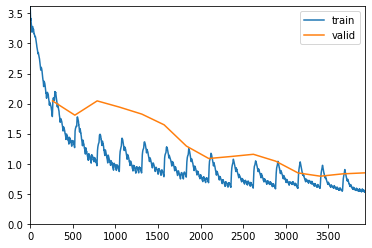

In [27]:
learn.fit_one_cycle(n_epoch=15, lr_max=1e-2)

In [20]:
model = learn.model

In [21]:
correct = 0
model.reset()
ys = []
ps = []
for x,y in valid_dl:
    p = model(x).argmax(dim=1)
    ys.append(y)
    ps.append(p)
ys = torch.cat(ys)
ps = torch.cat(ps)

In [22]:
(ys==ps).float().mean()

tensor(0.7127)

In [23]:
ys

tensor([18,  8, 26,  ..., 17,  8, 28])

In [24]:
ys = [idx2word[i.item()] for i in ys]
ps = [idx2word[i.item()] for i in ps]

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

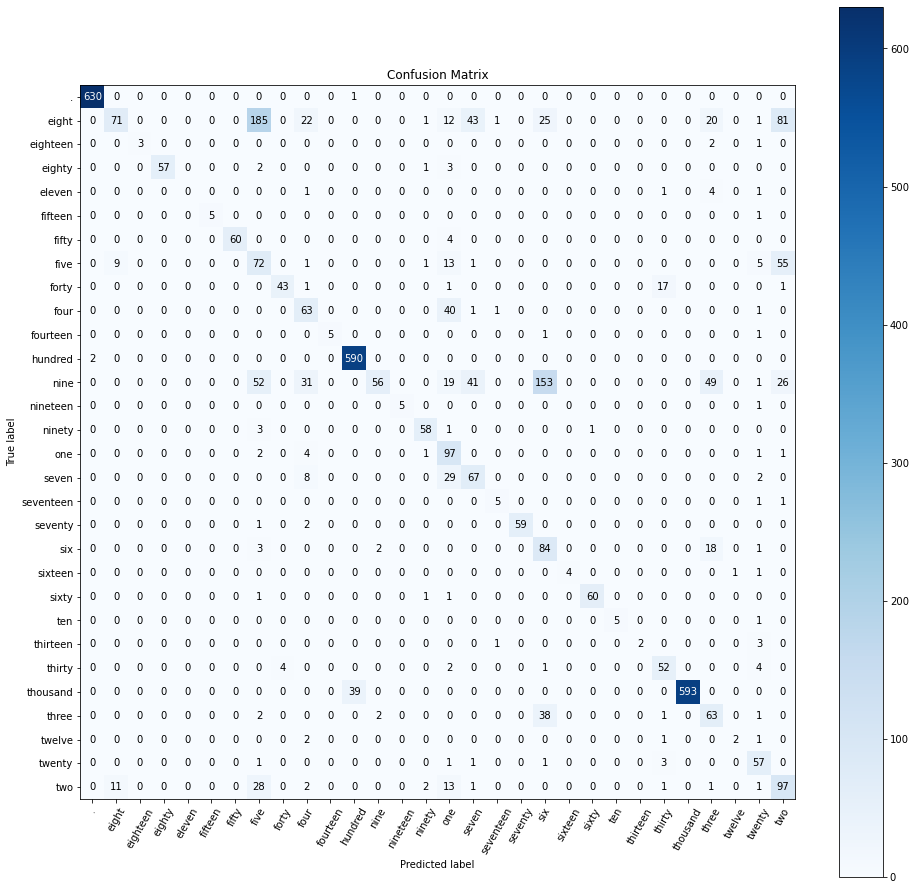

In [25]:
import scikitplot
scikitplot.metrics.plot_confusion_matrix(ys, ps, figsize=(16,16), x_tick_rotation=60)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

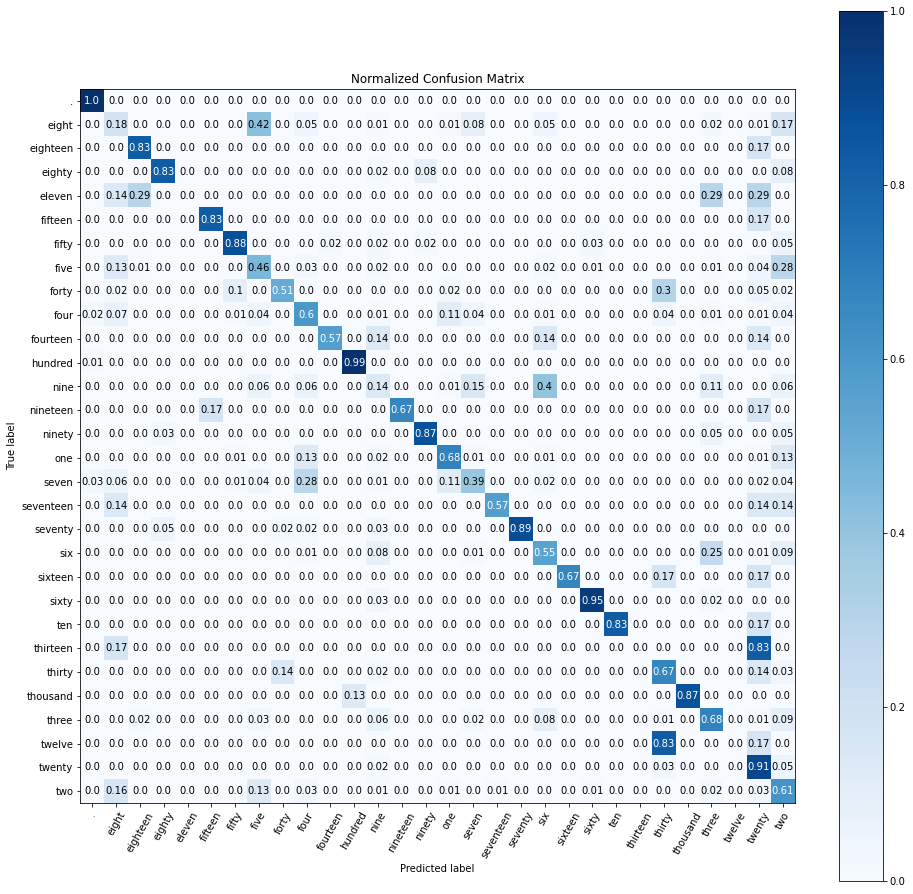

In [33]:
scikitplot.metrics.plot_confusion_matrix(ys, ps, figsize=(16,16), x_tick_rotation=60, normalize=True)

### Check that the matrix are the same

In [19]:
model.i_h.weight[:2,:2]

tensor([[-0.8551,  0.5428],
        [-1.4173,  0.8793]], grad_fn=<SliceBackward>)

In [20]:
model.h_o.weight[:2,:2]

tensor([[-0.8551,  0.5428],
        [-1.4173,  0.8793]], grad_fn=<SliceBackward>)